In [1]:
import pandas_datareader.data as web
import datetime as datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# read data
df_cols=['A229RX0Q048SBEA', 'A794RX0Q048SBEA']
orig_df = web.DataReader(df_cols, 'fred' ,start = datetime.datetime(1947,1,1),end = datetime.datetime(2021,1,1))
df = orig_df.copy()
df

,A229RX0Q048SBEA,A794RX0Q048SBEA
DATE,,
1947-01-01,9727.0,8907.0
1947-04-01,9590.0,9014.0
1947-07-01,9801.0,9002.0
1947-10-01,9618.0,8964.0
1948-01-01,9758.0,8972.0
...,...,...
2020-01-01,45702.0,39810.0
2020-04-01,50399.0,35951.0
2020-07-01,47979.0,39122.0


In [2]:
# transform 
df = df.dropna(how='any')
index = pd.date_range(df.index[0], periods=df.shape[0], freq="QS")
df.set_index(index, inplace=True)
df['SAVING_PER_CAP'] = df['A229RX0Q048SBEA'] - 1.062*df ['A794RX0Q048SBEA']

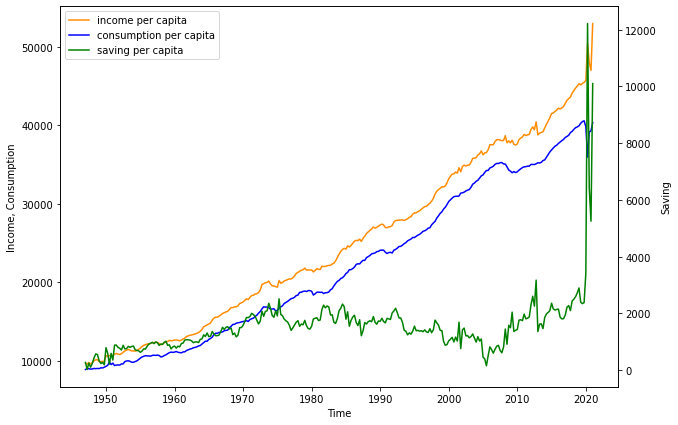

In [3]:
# 2 plot data

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)

# plot left axis
ln1 = ax1.plot(df.index, df['A229RX0Q048SBEA'],label="income per capita", color="darkorange")
ln2 = ax1.plot(df.index, df['A794RX0Q048SBEA'],label="consumption per capita", color="blue")
             
# plot right axis
ax2 = ax1.twinx()             
ln3 = ax2.plot(df.index, df['SAVING_PER_CAP'], label="saving per capita", color="green")

#setting
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

ax1.set_xlabel('Time')
ax1.set_ylabel('Income, Consumption')
ax2.set_ylabel('Saving')

# show
plt.show()

# save
fig.savefig("problem4-2.png")

In [4]:
from statsmodels.tsa.api import VAR

# 3 estimating VAR(2)
df['diff_y'] = df['A229RX0Q048SBEA'].diff(1).dropna(how='any')
df_var = pd.concat([df["diff_y"] , df['SAVING_PER_CAP']], axis=1)
df_var = df_var['1953-04-01':'1984-10-01']
df_var
model = VAR(df_var)
result = model.fit(2, trend='nc')

In [5]:
# summary
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Jun, 2021
Time:                     15:59:35
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.7245
Nobs:                     125.000    HQIC:                   19.6170
Log likelihood:          -1568.20    FPE:                3.07358e+08
AIC:                      19.5435    Det(Omega_mle):     2.88593e+08
--------------------------------------------------------------------
Results for equation diff_y
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
L1.diff_y                 0.360779         0.114171            3.160           0.002
L1.SAVING_PER_CAP        -0.394333         0.134813           -2.925           0.003
L2.diff_y                 0.033027         

In [6]:
# testable restriction 1

coefs = result.coefs # coefficient matrixes

r = 1/99 # interest rate

ols_X =pd.DataFrame({'diff_y_shif1': df['diff_y'].shift(1)['1953-04-01':'1984-10-01'],
                    'diff_y_shif2': df['diff_y'].shift(2)['1953-04-01':'1984-10-01'],
                    'saving_shf1': df['SAVING_PER_CAP'].shift(1)['1953-04-01':'1984-10-01'],
                   'saving_shf2': df['SAVING_PER_CAP'].shift(2)['1953-04-01':'1984-10-01']})
ols_X.set_index(df_var.index, inplace=True)

ols_y = df_var["SAVING_PER_CAP"]-df_var["diff_y"]-(1+r)*ols_X["saving_shf1"]


model = sm.OLS(ols_y, ols_X)
res = model.fit()

print(res.summary())
hypotheses = 'diff_y_shif1 = 0, diff_y_shif2 = 0, saving_shf1 = 0, saving_shf2 = 0'
res.f_test(hypotheses)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.474
Model:                            OLS   Adj. R-squared (uncentered):              0.457
Method:                 Least Squares   F-statistic:                              27.71
Date:                Wed, 23 Jun 2021   Prob (F-statistic):                    2.10e-16
Time:                        15:59:35   Log-Likelihood:                         -792.18
No. Observations:                 127   AIC:                                      1592.
Df Residuals:                     123   BIC:                                      1604.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[27.70595463]]), p=2.0978536259451027e-16, df_denom=123, df_num=4>

In [7]:
# 4 testable restriction
model = VAR(df_var)
result = model.fit(1, trend="nc")
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Jun, 2021
Time:                     15:59:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.6719
Nobs:                     126.000    HQIC:                   19.6185
Log likelihood:          -1587.23    FPE:                3.19376e+08
AIC:                      19.5819    Det(Omega_mle):     3.09473e+08
--------------------------------------------------------------------
Results for equation diff_y
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
L1.diff_y                 0.133488         0.092334            1.446           0.148
L1.SAVING_PER_CAP         0.056118         0.011859            4.732           0.000

Results for equation SAVING_PER_CAP
      

In [8]:
# Granger test
test_results = result.test_causality(causing='SAVING_PER_CAP', caused='diff_y', kind="f", signif=0.05)
test_results.summary()

Test statistic,Critical value,p-value,df
22.39,3.879,0.000,"(1, 248)"
